In [44]:
!pip install datasets numpy transformers scikit-learn numpy pandas duckdb matplotlib itables torch transformers[torch] seaborn

In [45]:
import os
from functools import partial
from itables import show
from itertools import chain
from pathlib import Path
from typing import Dict, List, Tuple

import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EvalPrediction
)

In [93]:
MODELS = {
    "bert": [
        "lyeonii/bert-tiny",
        "lyeonii/bert-mini",
        "lyeonii/bert-small",
        "lyeonii/bert-medium",
        "google-bert/bert-base-uncased",
        "google-bert/bert-large-uncased"
    ],
    "roberta": [
        "smallbenchnlp/roberta-small",
        "JackBAI/roberta-medium",
        "FacebookAI/roberta-base",
        "FacebookAI/roberta-large"
    ]
}

DATASETS = {
    "toxic_spans": load_dataset("heegyu/toxic-spans"),
    "cad": load_dataset("BoringAnt1793/paired_sentiment_datasets"),
}


def preprocess_function(examples, tokenizer):
    return tokenizer(
        examples["text_of_post"],
        truncation=True,
        padding="max_length",
        max_length=256,
        return_attention_mask=True,
        return_tensors=None
        
    )

def preprocess_labels(examples):
    examples["labels"] = examples["toxic"]
    return examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
def compute_metrics(eval_pred: EvalPrediction) -> Dict:
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_and_evaluate_model(model_name: str, dataset_name: str) -> dict:
    torch.cuda.empty_cache()

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        torchscript=True
    ).to(device)

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        model_max_length=256
    )

    tokenized_datasets = DATASETS[dataset_name].map(
        partial(preprocess_function, tokenizer=tokenizer),
        batched=True,
        batch_size=1000,
        num_proc=4
    )

    tokenized_datasets = tokenized_datasets.map(
        preprocess_labels,
        batched=True,
        num_proc=4
    )

    columns_to_remove = [
        "text_of_post", "toxic", "probability", "position",
        "type", "support", "position_probability"
    ]
    tokenized_datasets = tokenized_datasets.remove_columns(columns_to_remove)
    tokenized_datasets.set_format("torch")

    optimal_batch_size = 32
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        optimal_batch_size = int(min(32 * (gpu_memory / 8), 128))

    output_dir = Path.cwd() / "results" / f"{model_name.replace('/', '_')}_{dataset_name}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=optimal_batch_size,
        per_device_eval_batch_size=optimal_batch_size * 2,
        num_train_epochs=6,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",
        logging_steps=10,
        save_total_limit=2,
        fp16=torch.cuda.is_available(),
        gradient_checkpointing=True,
        dataloader_num_workers=4,
        dataloader_pin_memory=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    print("Starting training...")
    trainer.train()

    print("Evaluating model...")
    eval_results = trainer.evaluate()

    model.save_pretrained(
        output_dir,
        save_config=True,
        safe_serialization=True  # Use safe serialization for better compatibility
    )
    tokenizer.save_pretrained(output_dir)
    eval_results["model_name"] = model_name
    eval_results["dataset_name"] = dataset_name
    eval_stats = pd.DataFrame([eval_results])
    eval_stats.to_parquet(Path(output_dir) / "EvalStats.parquet")

    return eval_results

In [94]:
eval_stats = train_and_evaluate_model(MODELS["bert"][1], "toxic_spans")
print(eval_stats)

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679200,0.667243,0.596000,0.595156,0.669261,0.630037
2,0.659900,0.659353,0.593000,0.579025,0.762646,0.658270
3,0.638100,0.642093,0.614000,0.619403,0.645914,0.632381
4,0.621900,0.637826,0.631000,0.648262,0.616732,0.632104
5,0.611500,0.638581,0.637000,0.638532,0.677043,0.657224
6,0.609900,0.640392,0.629000,0.622222,0.708171,0.662420


Evaluating model...


{'eval_loss': 0.6403921842575073, 'eval_accuracy': 0.629, 'eval_precision': 0.6222222222222222, 'eval_recall': 0.708171206225681, 'eval_f1': 0.6624203821656051, 'eval_runtime': 0.2844, 'eval_samples_per_second': 3515.912, 'eval_steps_per_second': 59.771, 'epoch': 6.0, 'model_name': 'lyeonii/bert-mini', 'dataset_name': 'toxic_spans'}


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(


In [ ]:
for model_name in chain(*MODELS.values()):
    try:
        train_and_evaluate_model(model_name, "toxic_spans")
    except Exception as e:
        print(f"model_name {model_name} failed with error: {e}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.681800,0.674490,0.598000,0.603321,0.636187,0.619318
2,0.668800,0.670096,0.602000,0.597973,0.688716,0.640145
3,0.670300,0.666867,0.603000,0.600688,0.678988,0.637443
4,0.660300,0.664531,0.610000,0.611913,0.659533,0.634831
5,0.672500,0.663929,0.611000,0.607573,0.686770,0.644749
6,0.663000,0.663563,0.610000,0.606897,0.684825,0.643510


Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Starting training...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.656000,0.638185,0.637000,0.631763,0.704280,0.666053
2,0.621400,0.631261,0.658000,0.643813,0.749027,0.692446
3,0.631700,0.624218,0.654000,0.652727,0.698444,0.674812
4,0.557300,0.625797,0.653000,0.661509,0.665370,0.663434
5,0.574100,0.632562,0.656000,0.650177,0.715953,0.681481
6,0.561800,0.635651,0.660000,0.650000,0.733463,0.689214


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Starting training...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.649400,0.641921,0.635000,0.626058,0.719844,0.669683
2,0.613100,0.622281,0.667000,0.660177,0.725681,0.691381
3,0.619700,0.625885,0.667000,0.695464,0.626459,0.659161
4,0.531000,0.628902,0.675000,0.690141,0.667315,0.678536
5,0.545900,0.632654,0.671000,0.676864,0.688716,0.682739
6,0.533200,0.635942,0.672000,0.673507,0.702335,0.687619


Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Starting training...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.637000,0.632026,0.657000,0.639935,0.760700,0.695111
2,0.596000,0.622635,0.666000,0.650000,0.758755,0.700180
3,0.583600,0.642025,0.667000,0.726817,0.564202,0.635268
4,0.505300,0.659104,0.675000,0.687129,0.675097,0.681060
5,0.482300,0.680277,0.662000,0.673913,0.663424,0.668627
6,0.432700,0.696111,0.667000,0.671078,0.690661,0.680729


Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.619800,0.645085,0.660000,0.636792,0.787938,0.704348
2,0.579100,0.613933,0.677000,0.667250,0.741245,0.702304
3,0.513600,0.683220,0.642000,0.696970,0.536965,0.606593
4,0.435700,0.746712,0.660000,0.648973,0.737354,0.690346
5,0.345400,0.802558,0.649000,0.649541,0.688716,0.668555
6,0.302500,0.846467,0.655000,0.662188,0.671206,0.666667


Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at smallbenchnlp/roberta-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...
model_name smallbenchnlp/roberta-small failed with error: The expanded size of the tensor (256) must match the existing size (128) at non-singleton dimension 1.  Target sizes: [30, 256].  Tensor sizes: [1, 128]


model.safetensors:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at JackBAI/roberta-medium and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Starting training...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.675400,0.665371,0.589000,0.579109,0.733463,0.647210
2,0.623500,0.642025,0.640000,0.638989,0.688716,0.662921
3,0.630400,0.644277,0.647000,0.700748,0.546693,0.614208
4,0.578000,0.646503,0.650000,0.665992,0.640078,0.652778
5,0.601700,0.649980,0.644000,0.660569,0.632296,0.646123
6,0.592700,0.654057,0.632000,0.634191,0.671206,0.652174


model.safetensors:   0%|          | 0.00/155M [00:00<?, ?B/s]

Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Starting training...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.628100,0.663585,0.652000,0.640678,0.735409,0.684783
2,0.599600,0.633651,0.651000,0.632000,0.768482,0.693591
3,0.575500,0.651201,0.665000,0.703872,0.601167,0.648478
4,0.508800,0.663772,0.654000,0.661538,0.669261,0.665377
5,0.467500,0.697674,0.649000,0.653484,0.675097,0.664115
6,0.467300,0.722339,0.645000,0.647495,0.678988,0.662868


Evaluating model...


/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/modeling_utils.py:2773: UserWarning: `save_config` is deprecated and will be removed in v5 of Transformers. Use `is_main_process` instead.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

/home/nathanhuey/.miniforge3/envs/cs260d/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_4312/960874646.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.667500,0.643663,0.643000,0.625199,0.762646,0.687117
2,0.623300,0.620374,0.658000,0.646259,0.739300,0.689655
3,0.613000,0.642339,0.666000,0.729592,0.556420,0.631347
4,0.552300,0.625239,0.663000,0.658318,0.715953,0.685927


In [95]:
evals = duckdb.read_parquet("/home/nathanhuey/coding/ucla/cs260d/results/*/EvalStats.parquet").df()
show(evals)

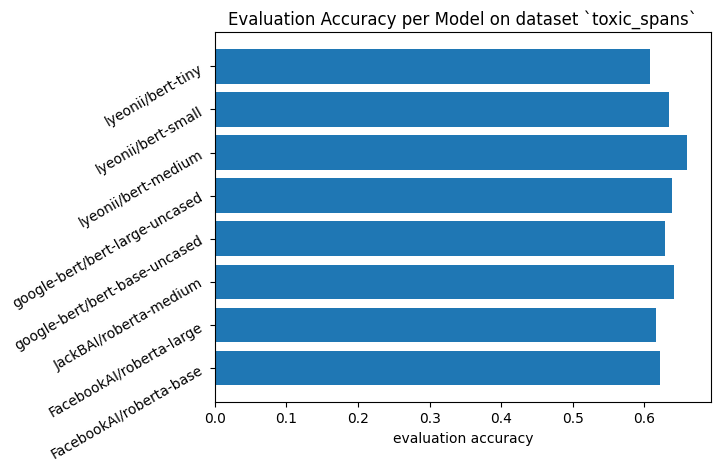

In [50]:
rows = evals[evals["dataset_name"] == "toxic_spans"]
plt.barh(
    y=evals["model_name"], 
    width=rows["eval_accuracy"]
)
plt.yticks(rotation=30)
plt.title("Evaluation Accuracy per Model on dataset `toxic_spans`")
plt.xlabel("evaluation accuracy")
plt.show()

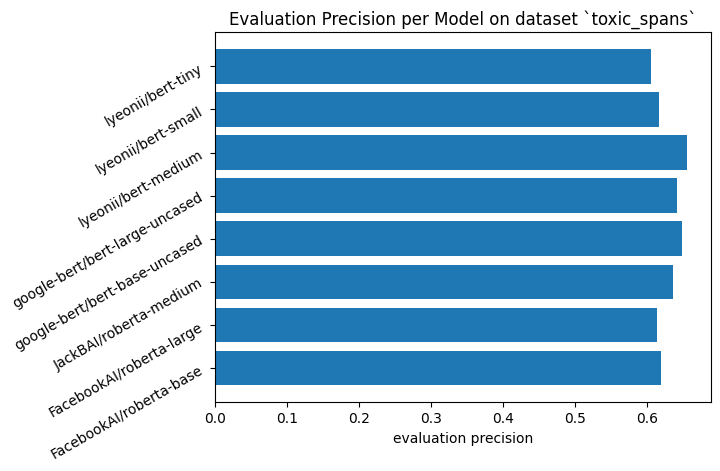

In [51]:
rows = evals[evals["dataset_name"] == "toxic_spans"]
plt.barh(
    y=evals["model_name"], 
    width=rows["eval_precision"]
)
plt.yticks(rotation=30)
plt.title("Evaluation Precision per Model on dataset `toxic_spans`")
plt.xlabel("evaluation precision")
plt.show()

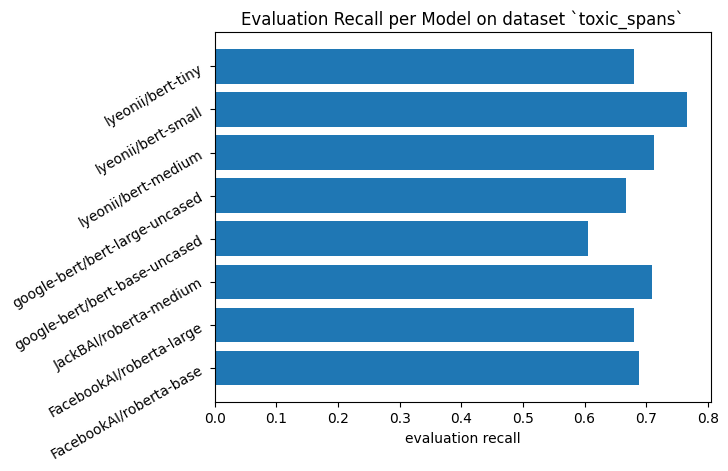

In [52]:
rows = evals[evals["dataset_name"] == "toxic_spans"]
plt.barh(
    y=evals["model_name"], 
    width=rows["eval_recall"]
)
plt.yticks(rotation=30)
plt.title("Evaluation Recall per Model on dataset `toxic_spans`")
plt.xlabel("evaluation recall")
plt.show()

In [2]:
for model_name in chain(*MODELS.values()):
    try:
        train_and_evaluate_model(model_name, "cad")
    except Exception as e:
        print(f"model_name {model_name} failed with error: {e}")

NameError: name 'chain' is not defined

In [26]:
training_stats = pd.read_csv("./training_stats.csv")
conn = duckdb.connect()
show(training_stats)

In [63]:
desired_bert_order = [
    'lyeonii/bert-tiny',
    'lyeonii/bert-small',
    'lyeonii/bert-medium',
    'google-bert/bert-base-uncased',
    'google-bert/bert-large-uncased',
]

desired_roberta_order = [
    'JackBAI/roberta-medium',
    'FacebookAI/roberta-base',
    'FacebookAI/roberta-large'
]

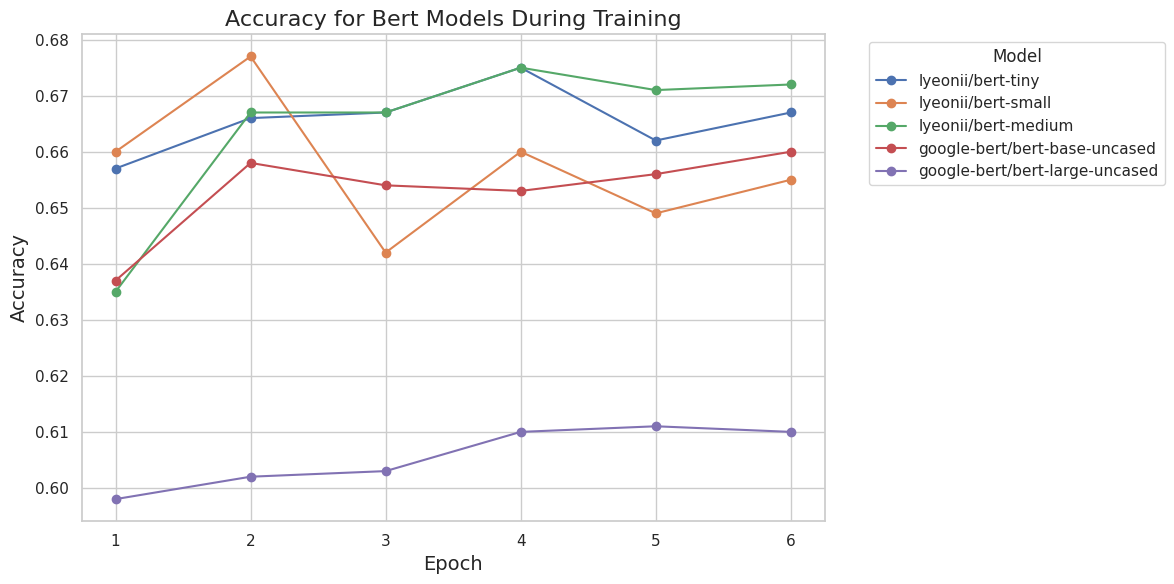

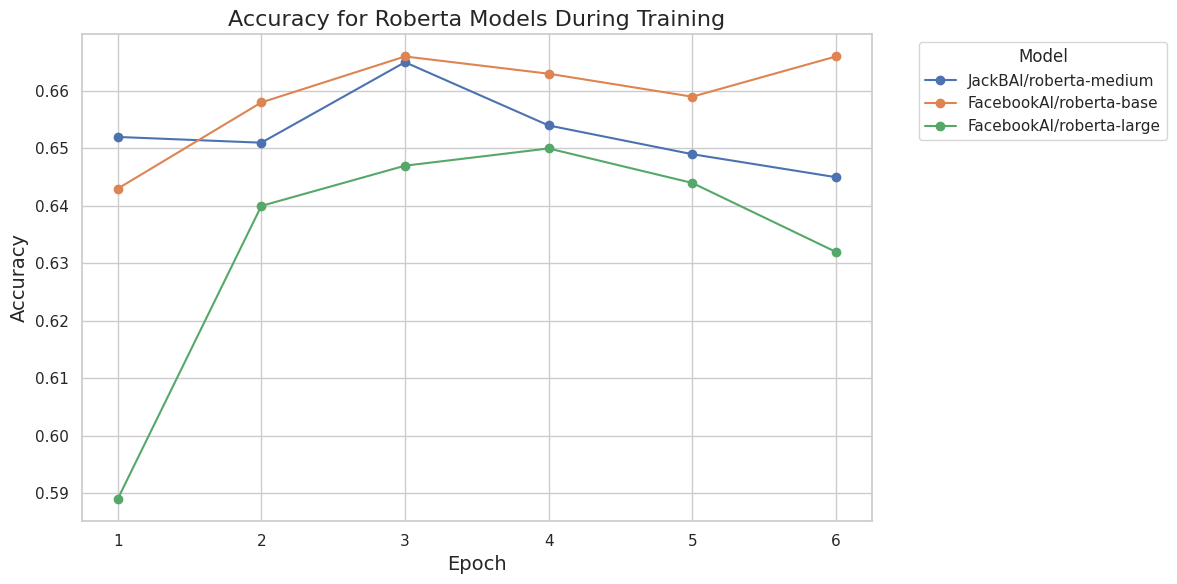

In [68]:
accuracy_stats = conn.query("""
SELECT Epoch, Accuracy, Model
FROM training_stats
""").df()
pivoted_accuracy_stats = conn.query("""
SELECT
    Model AS Model,
    MAX(CASE WHEN Epoch = 1 THEN Accuracy END) AS Accuracy_1,
    MAX(CASE WHEN Epoch = 2 THEN Accuracy END) AS Accuracy_2,
    MAX(CASE WHEN Epoch = 3 THEN Accuracy END) AS Accuracy_3,
    MAX(CASE WHEN Epoch = 4 THEN Accuracy END) AS Accuracy_4,
    MAX(CASE WHEN Epoch = 5 THEN Accuracy END) AS Accuracy_5,
    MAX(CASE WHEN Epoch = 6 THEN Accuracy END) AS Accuracy_6
FROM accuracy_stats
GROUP BY Model
ORDER BY Model;
""").df()


# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_accuracy_stats['Model']:
    if model not in MODELS["bert"]:
        continue
    model_data = pivoted_accuracy_stats[pivoted_accuracy_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy for Bert Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_bert_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_accuracy_stats['Model']:
    if model not in MODELS["roberta"]:
        continue
    model_data = pivoted_accuracy_stats[pivoted_accuracy_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy for Roberta Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_roberta_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

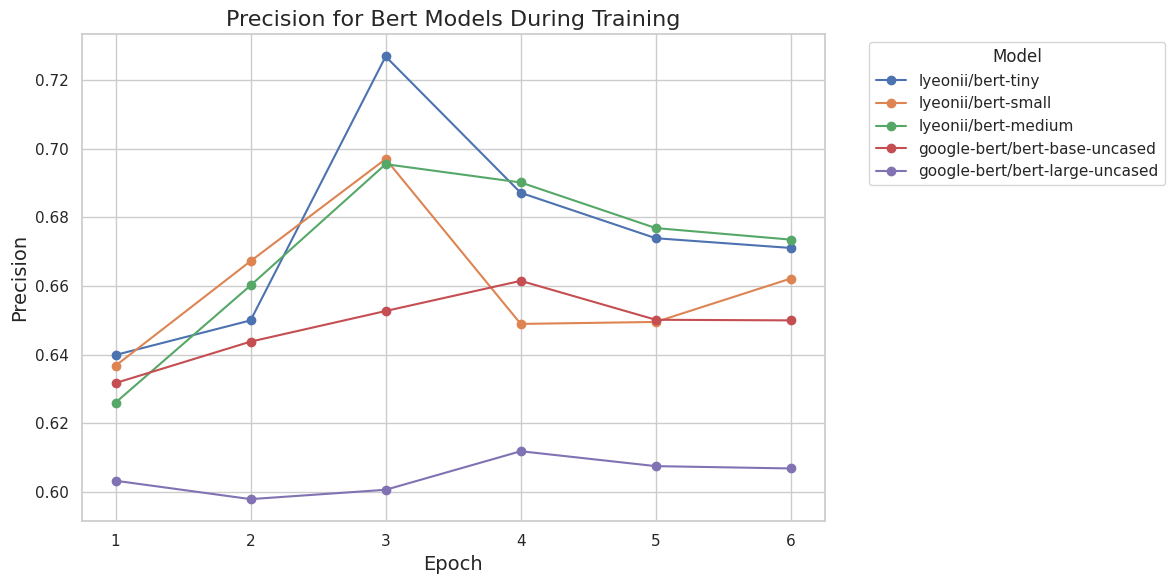

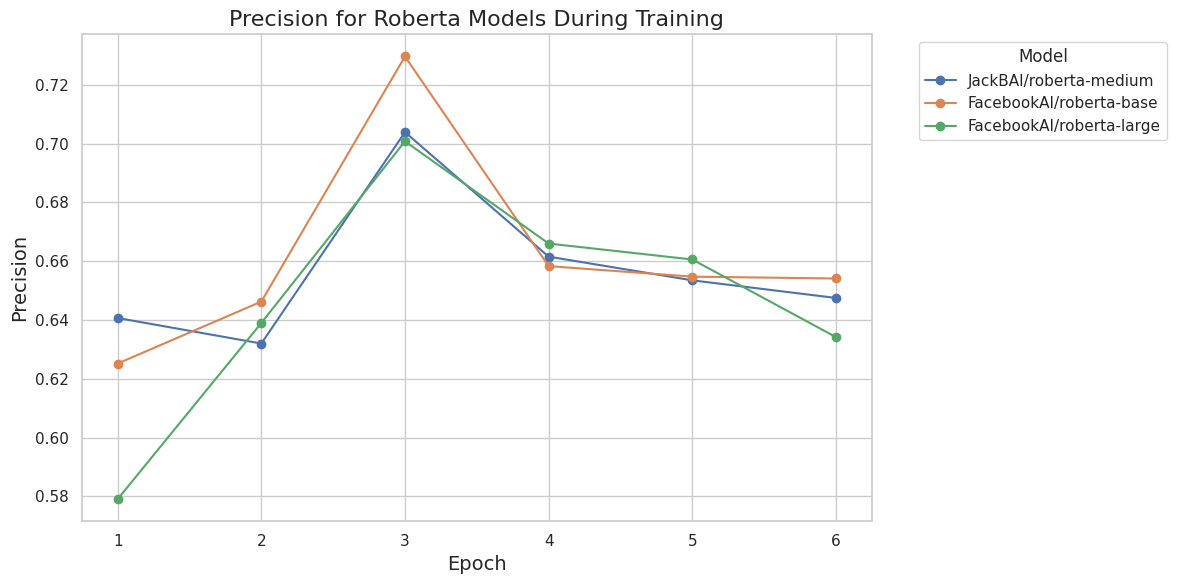

In [69]:
precision_stats = conn.query("""
SELECT Epoch, Precision, Model
FROM training_stats
""").df()
precision_stats
pivoted_precision_stats = conn.query("""
SELECT
    Model AS Model,
    MAX(CASE WHEN Epoch = 1 THEN Precision END) AS Precision_1,
    MAX(CASE WHEN Epoch = 2 THEN Precision END) AS Precision_2,
    MAX(CASE WHEN Epoch = 3 THEN Precision END) AS Precision_3,
    MAX(CASE WHEN Epoch = 4 THEN Precision END) AS Precision_4,
    MAX(CASE WHEN Epoch = 5 THEN Precision END) AS Precision_5,
    MAX(CASE WHEN Epoch = 6 THEN Precision END) AS Precision_6
FROM precision_stats
GROUP BY Model
ORDER BY Model;
""").df()


# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_precision_stats['Model']:
    if model not in MODELS["bert"]:
        continue
    model_data = pivoted_precision_stats[pivoted_precision_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision for Bert Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_bert_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_precision_stats['Model']:
    if model not in MODELS["roberta"]:
        continue
    model_data = pivoted_precision_stats[pivoted_precision_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision for Roberta Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_roberta_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

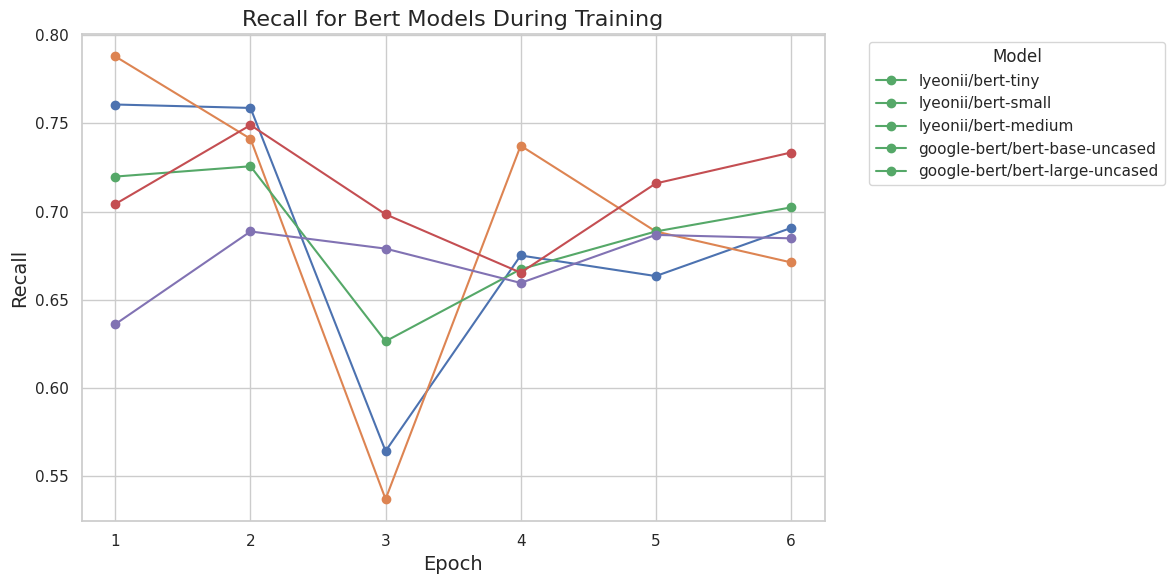

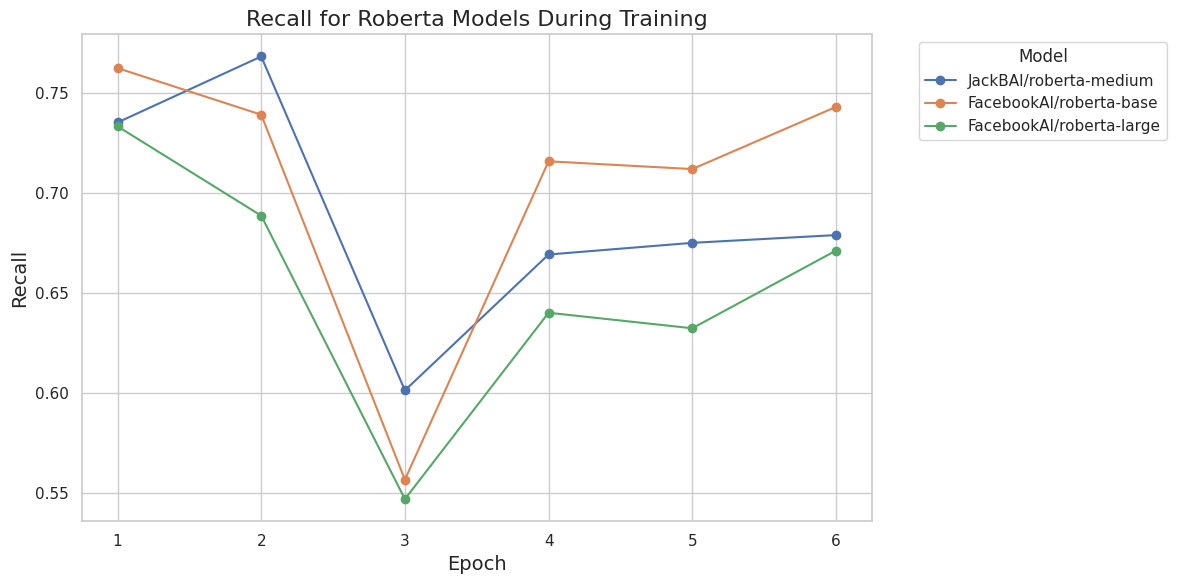

In [70]:
recall_stats = conn.query("""
SELECT Epoch, Recall, Model
FROM training_stats
""").df()
pivoted_recall_stats = conn.query("""
SELECT
    Model AS Model,
    MAX(CASE WHEN Epoch = 1 THEN Recall END) AS Recall_1,
    MAX(CASE WHEN Epoch = 2 THEN Recall END) AS Recall_2,
    MAX(CASE WHEN Epoch = 3 THEN Recall END) AS Recall_3,
    MAX(CASE WHEN Epoch = 4 THEN Recall END) AS Recall_4,
    MAX(CASE WHEN Epoch = 5 THEN Recall END) AS Recall_5,
    MAX(CASE WHEN Epoch = 6 THEN Recall END) AS Recall_6
FROM recall_stats
GROUP BY Model
ORDER BY Model;
""").df()


# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_recall_stats['Model']:
    if model not in MODELS["bert"]:
        continue
    model_data = pivoted_recall_stats[pivoted_recall_stats['Model'] == model]
    line, plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Recall for Bert Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_bert_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_recall_stats['Model']:
    if model not in MODELS["roberta"]:
        continue
    model_data = pivoted_recall_stats[pivoted_recall_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Recall", fontsize=14)
plt.title("Recall for Roberta Models During Training", fontsize=16)

# Add a legend
plt.legend(lines,desired_roberta_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

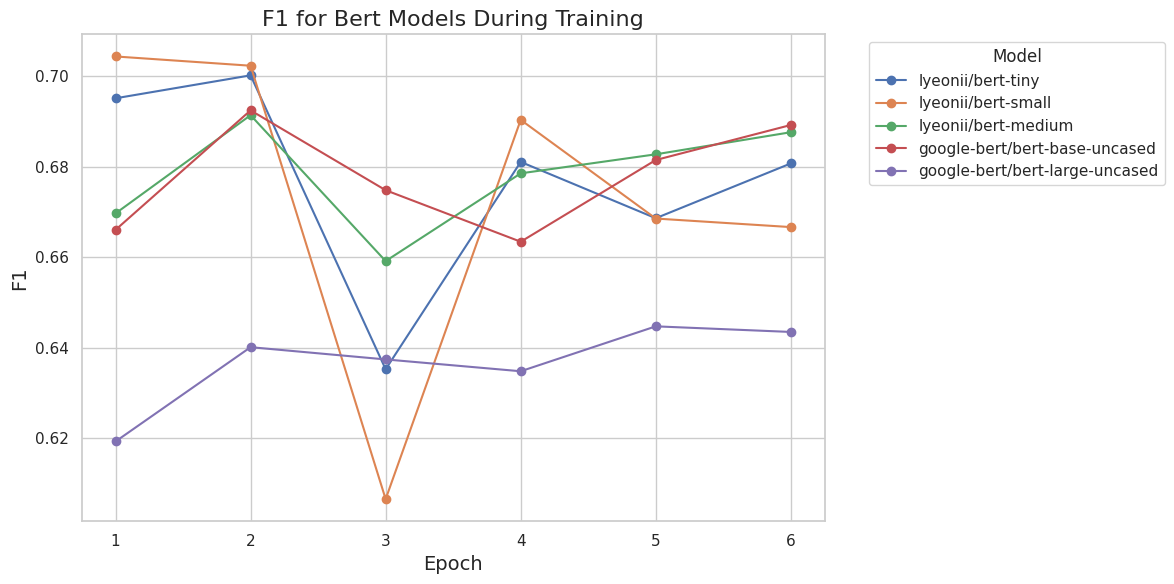

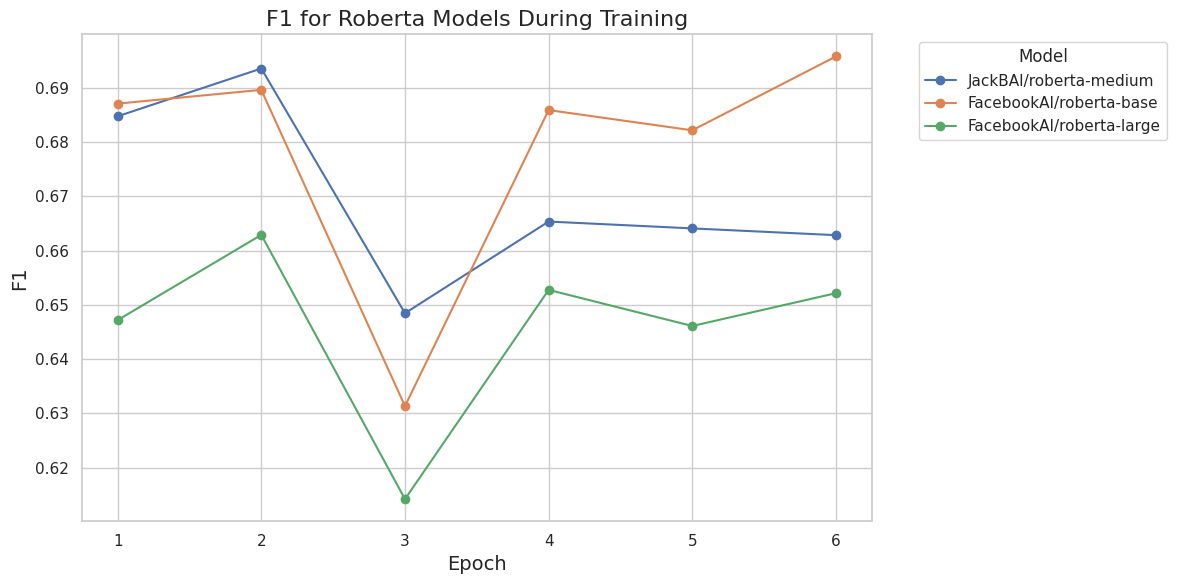

In [72]:
f1_stats = conn.query("""
SELECT Epoch, F1, Model
FROM training_stats
""").df()
pivoted_f1_stats = conn.query("""
SELECT
    Model AS Model,
    MAX(CASE WHEN Epoch = 1 THEN F1 END) AS F1_1,
    MAX(CASE WHEN Epoch = 2 THEN F1 END) AS F1_2,
    MAX(CASE WHEN Epoch = 3 THEN F1 END) AS F1_3,
    MAX(CASE WHEN Epoch = 4 THEN F1 END) AS F1_4,
    MAX(CASE WHEN Epoch = 5 THEN F1 END) AS F1_5,
    MAX(CASE WHEN Epoch = 6 THEN F1 END) AS F1_6
FROM f1_stats
GROUP BY Model
ORDER BY Model;
""").df()


# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_f1_stats['Model']:
    if model not in MODELS["bert"]:
        continue
    model_data = pivoted_f1_stats[pivoted_f1_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("F1", fontsize=14)
plt.title("F1 for Bert Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_bert_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# Set the plot style
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Loop through each model and plot its precision values
lines = []
for model in pivoted_f1_stats['Model']:
    if model not in MODELS["roberta"]:
        continue
    model_data = pivoted_f1_stats[pivoted_f1_stats['Model'] == model]
    line, = plt.plot([1, 2, 3, 4, 5, 6], model_data.iloc[0, 1:], label=model, marker='o')
    lines.append(line)

# Add labels and title
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("F1", fontsize=14)
plt.title("F1 for Roberta Models During Training", fontsize=16)

# Add a legend
plt.legend(lines, desired_roberta_order, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [73]:
show(evals)

In [96]:
accuracy_eval_df = conn.query("""
SELECT model_name, eval_accuracy
FROM evals
WHERE model_name IN ('lyeonii/bert-tiny', 'lyeonii/bert-mini', 'lyeonii/bert-small', 'lyeonii/bert-medium', 'google-bert/bert-base-uncased', 'google-bert/bert-large-uncased') 
""").df()
bert_mapping = {
    "lyeonii/bert-tiny": "BERT-Tiny",
    "lyeonii/bert-mini": "BERT-Mini",
    "lyeonii/bert-small": "BERT-Small",
    "lyeonii/bert-medium": "BERT-Medium",
    "google-bert/bert-base-uncased": "BERT-Base",
    "google-bert/bert-large-uncased": "BERT-Large",
}
accuracy_eval_df['model_name'] = accuracy_eval_df['model_name'].replace(bert_mapping)
accuracy_eval_df

,model_name,eval_accuracy
0,BERT-Base,0.667
1,BERT-Large,0.655
2,BERT-Medium,0.672
3,BERT-Mini,0.629
4,BERT-Small,0.660
5,BERT-Tiny,0.610


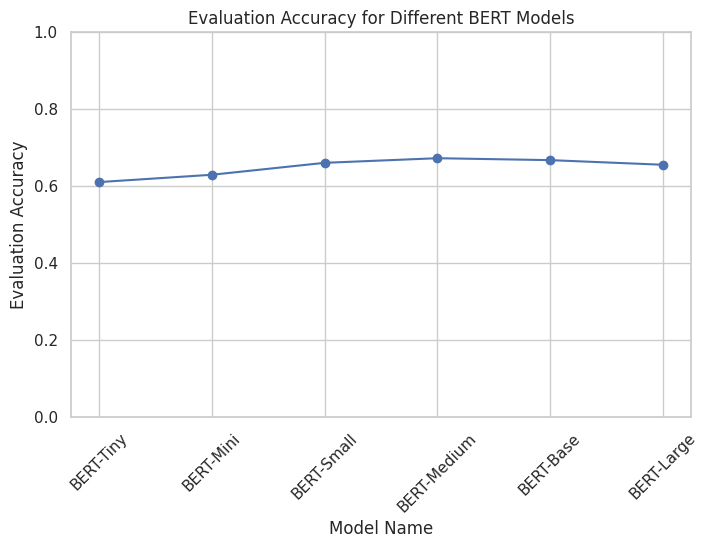

In [98]:
# Define the custom order for the models
model_order = ['BERT-Tiny', 'BERT-Mini', 'BERT-Small', 'BERT-Medium', 'BERT-Base', 'BERT-Large']

# Convert model_name to a categorical type with the specified order
accuracy_eval_df['model_name'] = pd.Categorical(accuracy_eval_df['model_name'], categories=model_order, ordered=True)

# Sort the DataFrame based on the custom order
df_sorted = accuracy_eval_df.sort_values('model_name')

# Plotting the sorted DataFrame
plt.figure(figsize=(8, 5))
plt.plot(df_sorted['model_name'], df_sorted['eval_accuracy'], marker='o', linestyle='-', color='b')
plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('Model Name')
plt.ylabel('Evaluation Accuracy')
plt.title('Evaluation Accuracy for Different BERT Models')

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()